In [4]:
import os.path

from sympy.printing.pytorch import torch

file_path = '/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_1.parquet'

In [5]:
import pandas as pd

edges_df = pd.read_parquet(file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_1.parquet'

In [19]:
edges_df

,u,i,ts,idx,rt,0,1,2,3,4
3797497,17684,18738,60000,3797498,1.0,0.0,0.0,1.0,0.0,0.0
3797498,35482,19355,60000,3797499,0.0,0.0,0.0,0.0,0.0,1.0
3797499,18679,59226,60000,3797500,1.0,0.0,0.0,1.0,0.0,0.0
3797500,33545,14046,60000,3797501,0.0,0.0,0.0,1.0,0.0,0.0
3797501,969,17869,60000,3797502,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7393462,10077,35136,119999,7393463,0.0,0.0,0.0,1.0,0.0,0.0
7393463,44631,44354,119999,7393464,1.0,0.0,0.0,0.0,0.0,1.0
7393464,37176,37400,119999,7393465,1.0,0.0,0.0,1.0,0.0,0.0
7393465,37106,22350,119999,7393466,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
u, i, ts = edges_df['u'].to_numpy(), edges_df['i'].to_numpy(), edges_df['ts'].to_numpy()

In [21]:
from temporal_random_walk import TemporalRandomWalk

temporal_random_walk = TemporalRandomWalk(is_directed=True, use_gpu=False)

In [22]:
from raphtory import Graph
g = Graph()

In [23]:
g.load_edges_from_pandas(
    df=edges_df,
    time="ts",
    src="u",
    dst="i"
)

In [24]:
temporal_random_walk.add_multiple_edges(u, i, ts)

In [26]:
import pandas as pd

df = pd.read_parquet('/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_100.parquet')

In [28]:
df

,u,i,ts,idx,rt,0,1,2,3,4
335204989,14938,14938,6000000,335204990,3.0,0.0,0.0,0.0,0.0,1.0
335204990,16284,17932,6000000,335204991,0.0,0.0,0.0,1.0,0.0,0.0
335204991,43759,28205,6000000,335204992,1.0,0.0,0.0,1.0,0.0,0.0
335204992,66999,66999,6000000,335204993,NaN,0.0,0.0,1.0,0.0,0.0
335204993,5870,2402,6000000,335204994,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
338246044,28012,37927,6059999,338246045,1.0,1.0,0.0,0.0,0.0,0.0
338246045,51804,20354,6059999,338246046,0.0,0.0,0.0,0.0,1.0,0.0
338246046,32740,32740,6059999,338246047,0.0,0.0,0.0,0.0,0.0,1.0
338246047,67001,31913,6059999,338246048,6.0,0.0,1.0,0.0,0.0,0.0


In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

def plot_contact_sequence(edges, output_path='contact-sequence.pdf'):
    timestamps = [edge[2] for edge in edges]
    max_ts_lim = np.max(timestamps) + np.max(timestamps) * 0.05

    nodes = sorted(set(u for u, v, _ in edges) | set(v for u, v, _ in edges))
    node_to_y = {node: i for i, node in enumerate(nodes)}

    # Use high-contrast colormap
    use_grayscale = False
    if use_grayscale:
        colors = [str(0.85 - 0.1 * (i % 4)) for i in range(len(nodes))]
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, len(nodes)))

    # Configure fonts for large display
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 12,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'text.usetex': False
    })

    fig, ax = plt.subplots(figsize=(8, 4))  # Large slide-friendly format

    # Background node bands and dashed timelines
    for i, node in enumerate(nodes):
        ax.axhspan(i - 0.4, i + 0.4, color=colors[i % len(colors)], alpha=0.15, zorder=0)
        ax.hlines(y=i, xmin=0, xmax=max_ts_lim, color='lightgray', linestyle='--', linewidth=0.6, zorder=1)

    # Y-axis: node labels
    ax.set_yticks(range(len(nodes)))
    ax.set_yticklabels([str(node) for node in nodes], fontweight='bold')
    ax.tick_params(axis='y', pad=6)

    # Arrows or self-loop markers
    for u, v, t in edges:
        y1, y2 = node_to_y[u], node_to_y[v]
        if y1 == y2:
            ax.plot([t], [y1], 'o', color='black', markersize=6, zorder=3)
        else:
            span = abs(y2 - y1)
            rad = 0.15 + 0.05 * span
            rad = rad if y1 < y2 else -rad

            arrow = FancyArrowPatch(
                (t, y1), (t, y2),
                connectionstyle=f"arc3,rad={rad}",
                arrowstyle='->',
                mutation_scale=18,
                linewidth=1.4,
                color='black',
                zorder=4
            )
            ax.add_patch(arrow)

    # Axis formatting
    ax.set_ylim(-1, len(nodes))
    ax.set_xlim(0, max_ts_lim)
    ax.set_xlabel("Time")
    ax.set_ylabel("Nodes")
    ax.grid(False)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(axis='x')

    # Save high-resolution PNG
    plt.tight_layout()
    plt.savefig(output_path, format='pdf')
    plt.show()

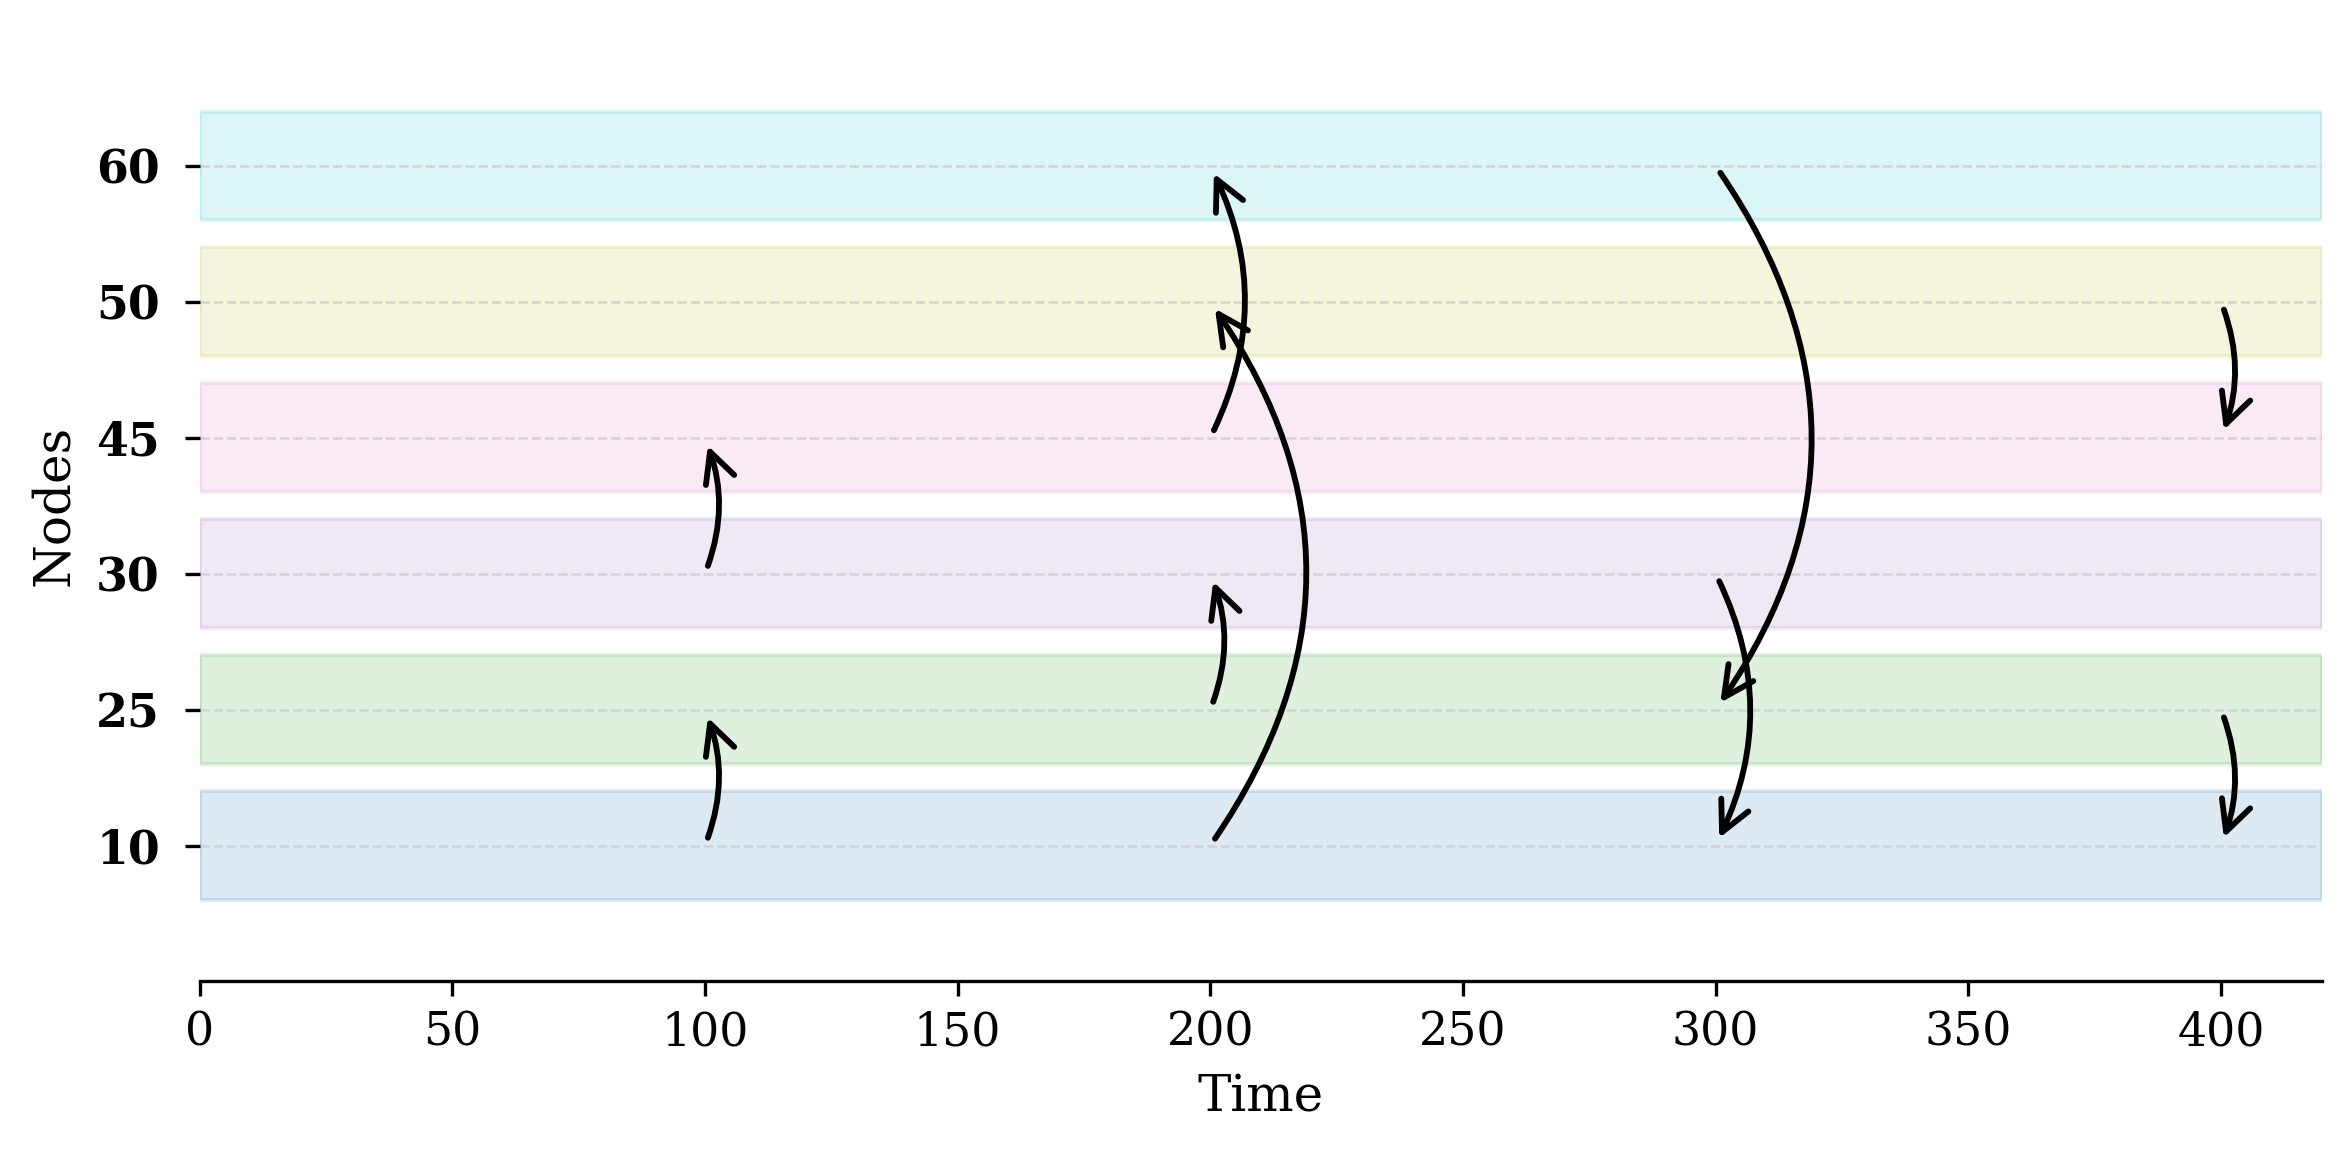

In [21]:
plot_contact_sequence([
    (10, 25, 100),
    (30, 45, 100),
    (25, 30, 200),
    (45, 60, 200),
    (10, 50, 200),
    (30, 10, 300),
    (60, 25, 300),
    (50, 45, 400),
    (25, 10, 400)
])

In [2]:
import os
import pandas as pd

file_dir = '/Volumes/traces/final_data_files/'

file_paths = [os.path.join(file_dir, f'data_{file_id}.parquet') for file_id in range(1440, 1680)]
dfs = [pd.read_parquet(file_path).sort_values(by='ts', ascending=True) for file_path in file_paths]

In [3]:
merged_df = pd.concat(dfs)

In [4]:
selected_df = merged_df[['u', 'i', 'ts']]

In [5]:
selected_df.to_parquet('/Users/ashfaqsalehin/Downloads/4_hour_data.parquet')

In [13]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/tgbl-subreddit 2/tgbl-subreddit_edgelist.csv')

all_ids = pd.concat([df['user_id'], df['item_id']]).unique()

# Create single encoder for all nodes
node_encoder = LabelEncoder()
node_encoder.fit(all_ids)

# Encode both columns using the same encoder
df['user_id'] = node_encoder.transform(df['user_id'])
df['item_id'] = node_encoder.transform(df['item_id'])

df = df[['user_id', 'item_id', 'timestamp']].copy()
df.columns = ['u', 'i', 'ts']

df['ts'] = df['ts'] - df['ts'].min()
df = df.sort_values('ts').reset_index(drop=True)

In [14]:
df.to_csv('/Users/ashfaqsalehin/Downloads/reddit.csv', index=False)

In [18]:
df = pd.read_csv('/Users/ashfaqsalehin/Downloads/wiki.csv')

In [19]:
df['ts'].unique()

array([ 0.        , 13.20056788, 26.40113576, 39.60170364, 52.80227152,
       66.0028394 ])

In [42]:
import pandas as pd

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/tgbl-flight-v2/tgbl-flight_edgelist_v2.csv')

In [43]:
df.columns

Index(['timestamp', 'src', 'dst', 'callsign', 'typecode'], dtype='object')

In [44]:
from sklearn.preprocessing import LabelEncoder

all_nodes = pd.concat([df['src'], df['dst']], ignore_index=True).unique()

# Initialize and fit label encoder on all unique nodes
label_encoder = LabelEncoder()
label_encoder.fit(all_nodes)

# Transform user_id and item_id using the same encoder
df['src'] = label_encoder.transform(df['src'])
df['dst'] = label_encoder.transform(df['dst'])

In [45]:
df = df[['src', 'dst', 'timestamp']]

In [46]:
df.columns = ['u', 'i', 'ts']
df = df.sort_values('ts').reset_index(drop=True)

original_min_ts = df['ts'].min()
if original_min_ts < 0:
    df['ts'] = df['ts'] - original_min_ts

In [47]:
df.to_csv('/Users/ashfaqsalehin/Documents/other_datasets/flight.csv', index=False)

In [48]:
df = pd.read_csv('/Users/ashfaqsalehin/Documents/other_datasets/flight.csv')
len(df)

67169570

In [1]:
from tgb.linkproppred.dataset import LinkPropPredDataset

name = "tgbl-coin"

dataset = LinkPropPredDataset(name=name, root="datasets", preprocess=True)

data = dataset.full_data

Dataset tgbl-coin version 2 not found.
Please download the latest version of the dataset.
Download started, this might take a while . . . 
Dataset title: tgbl-coin
Download completed 
Dataset directory is  /Users/ashfaqsalehin/PycharmProjects/temporal-random-walk-test/.venv/lib/python3.10/site-packages/tgb/datasets/tgbl_coin
file not processed, generating processed file
number of lines counted 22809486
numpy allocated


22809487it [00:50, 455805.56it/s]


In [19]:
full_data = dataset.full_data

In [20]:
train_sources = full_data['sources'][dataset.train_mask]
train_targets = full_data['destinations'][dataset.train_mask]
train_timestamps = full_data['timestamps'][dataset.train_mask]

val_sources = full_data['sources'][dataset.val_mask]
val_targets = full_data['destinations'][dataset.val_mask]
val_timestamps = full_data['timestamps'][dataset.val_mask]

test_sources = full_data['sources'][dataset.test_mask]
test_targets = full_data['destinations'][dataset.test_mask]
test_timestamps = full_data['timestamps'][dataset.test_mask]

In [21]:
dataset.load_val_ns()

In [ ]:
import torch

val_sources_tensor = torch.tensor(val_sources)
val_targets_tensor = torch.tensor(val_targets)
val_timestamps_tensor = torch.tensor(val_timestamps)

dataset.ns_sampler.query_batch(val_sources_tensor, )

In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/TEA-datasets/csv_datasets/yahoo-song.csv')
ts = df['ts'].to_numpy()
unique_timestamps = np.unique(ts)

unique_timestamps.sort()

In [98]:
len(unique_timestamps), list(unique_timestamps).index(264101580)

(4357526, 103517)

In [99]:
df = pd.read_parquet('/Users/ashfaqsalehin/Downloads/4_hour_data.parquet')

In [100]:
df

,u,i,ts
5789660015,65094,17932,86400000
5789660052,51804,51804,86400000
5789660053,44870,52118,86400000
5789660054,44870,22617,86400000
5789660055,64996,27884,86400000
...,...,...,...
6494499987,54423,18819,100799999
6494499986,67001,31913,100799999
6494500014,67001,62215,100799999
6494499999,64996,27884,100799999


In [101]:
unique_timestamps = np.unique(df['ts'].to_numpy())

In [1]:
import numpy as np
from typing import Tuple, Optional


def generate_temporal_graph(num_nodes: int,
                           num_edges: int,
                           num_timestamps: int,
                           time_range: Tuple[int, int] = (0, 1_000_000_000),
                           random_state: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if random_state is not None:
        np.random.seed(random_state)

    if num_edges <= 0:
        return np.array([]), np.array([]), np.array([])

    if num_timestamps <= 0 or num_nodes <= 0:
        raise ValueError("num_timestamps and num_nodes must be positive")

    # Step 1: Generate exactly num_timestamps unique timestamps
    min_time, max_time = time_range

    # Ensure we have enough range for unique timestamps
    time_span = max_time - min_time + 1
    if num_timestamps > time_span:
        raise ValueError(f"Cannot generate {num_timestamps} unique timestamps in range {time_range}")

    # Generate exactly num_timestamps unique timestamps
    unique_timestamps = np.random.choice(
        np.arange(min_time, max_time + 1, dtype=np.int64),
        size=num_timestamps,
        replace=False
    )
    unique_timestamps = np.sort(unique_timestamps)

    # Step 2: Randomly assign each edge to one of the timestamps
    edge_timestamps = np.random.choice(unique_timestamps, size=num_edges)

    # Step 3: Generate random source and target nodes (self-loops allowed)
    sources = np.random.randint(0, num_nodes, size=num_edges)
    targets = np.random.randint(0, num_nodes, size=num_edges)

    # Step 4: Sort everything by timestamp
    sort_indices = np.argsort(edge_timestamps)

    return (sources[sort_indices],
            targets[sort_indices],
            edge_timestamps[sort_indices])

In [5]:
np.logspace(start=1, stop=8, num=8, base=10, dtype=int)

array([       10,       100,      1000,     10000,    100000,   1000000,
        10000000, 100000000])

In [ ]:
df = pd.read_csv('/Users/ashfaqsalehin/Downloads/')